In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime

from statsmodels.tsa.seasonal import MSTL, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from data_prepro import get_energy_data_today

In [3]:
df_energy = get_energy_data_today(to_date="20231220")
print(df_energy.info())
df_energy.tail(5)

c:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
68 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78603 entries, 2014-12-31 23:00:00+00:00 to 2023-12-20 01:00:00+00:00
Freq: H
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   gesamt         78603 non-null  float64            
 1   timestamp_CET  78603 non-null  datetime64[ns, CET]
 2   weekday        78603 non-null  int32              
dtypes: datetime64[ns, CET](1), float64(1), int32(1)
memory usage: 2.1 MB
None


,gesamt,timestamp_CET,weekday
timestamp_UTC,,,
2023-12-19 21:00:00+00:00,52819.25,2023-12-19 22:00:00+01:00,1
2023-12-19 22:00:00+00:00,49462.25,2023-12-19 23:00:00+01:00,1
2023-12-19 23:00:00+00:00,45810.25,2023-12-20 00:00:00+01:00,2
2023-12-20 00:00:00+00:00,43947.50,2023-12-20 01:00:00+01:00,2
2023-12-20 01:00:00+00:00,42793.75,2023-12-20 02:00:00+01:00,2


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 337 entries, 2023-12-06 01:00:00+00:00 to 2023-12-20 01:00:00+00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gesamt  337 non-null    float64
dtypes: float64(1)
memory usage: 5.3 KB


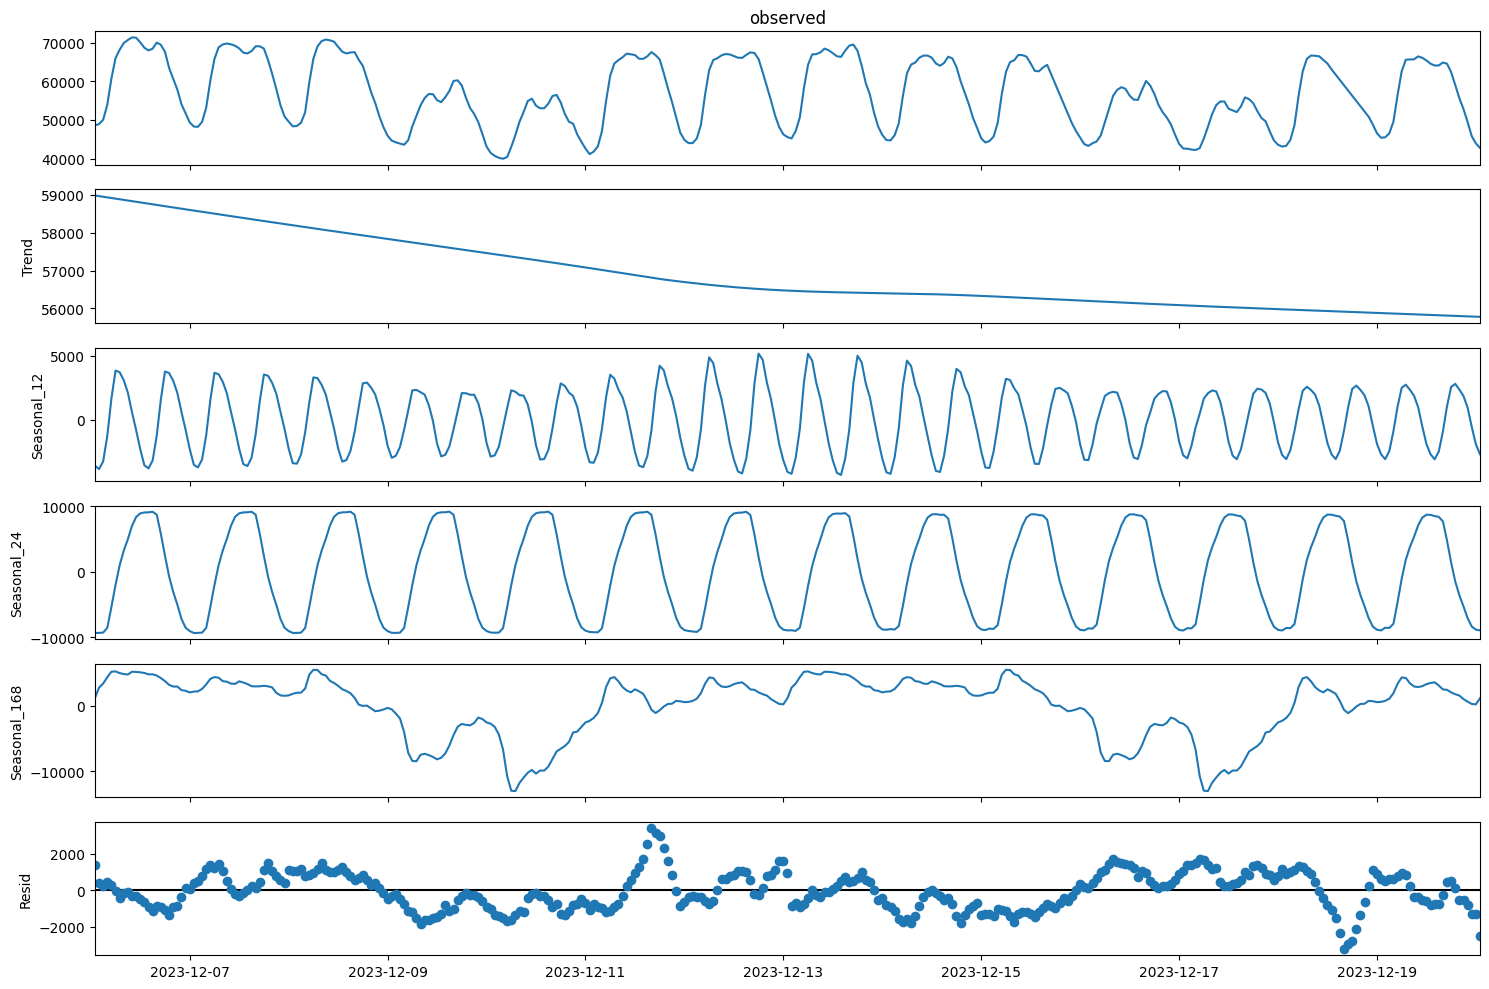

In [30]:
# take last n values only
n_last = 24*7*2 + 1
df_energy_small = df_energy.iloc[-n_last:][['gesamt']]

# take values from 2020-01-01 to 2023-01-01
# df_energy_small = df_energy.loc['2020-01-01':'2023-01-01'][['gesamt']]
df_energy_small.info()

mstl = MSTL(df_energy_small, periods=[12, 24, 24*7], iterate=1, 
            stl_kwargs={"seasonal_deg": 0,
                        "inner_iter": 2,
                        "outer_iter": 0})

res = mstl.fit()

plt.rc("figure", figsize=(15, 10))
plt.rc("font", size=10)

res.plot()
plt.tight_layout()
plt.show()

In [6]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.base import ForecastingHorizon


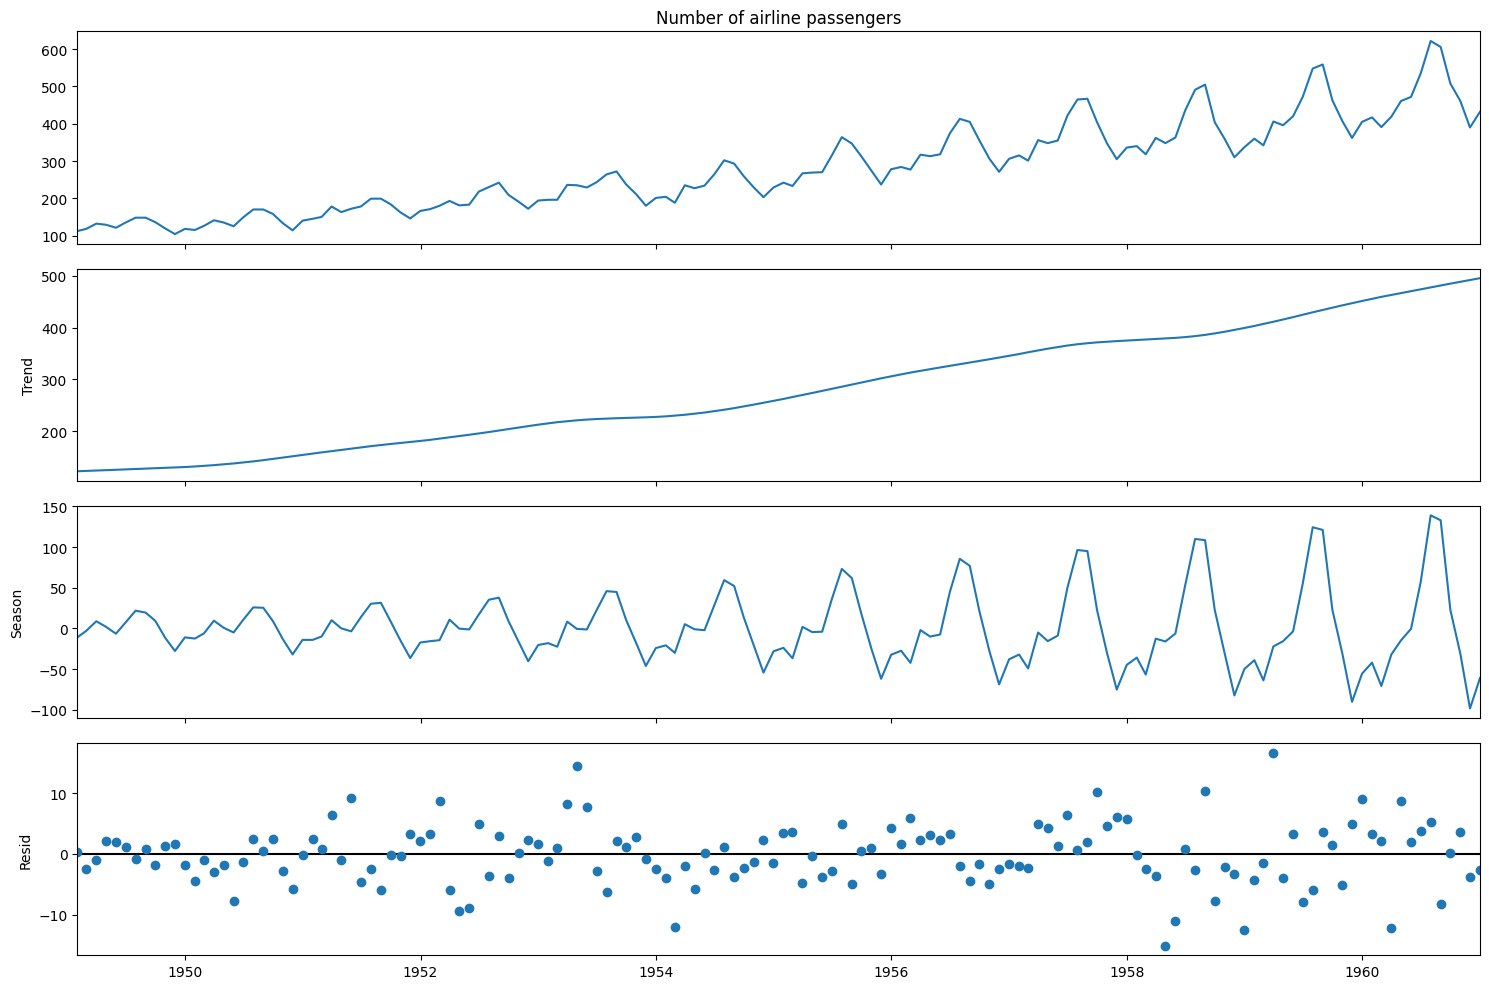

In [7]:
from sktime.datasets import load_airline

# Load univariate time series data
y = load_airline()
y.index = pd.date_range(start='1949-01-01', periods=len(y), freq='M')

# Use STL with the explicitly set frequency
res = STL(np.squeeze(y), period=12).fit()

plt.rc("figure", figsize=(15, 10))
plt.rc("font", size=10)

res.plot()
plt.show()

In [8]:
from sktime.datasets import load_airline
from sktime.forecasting.tbats import TBATS

y = load_airline()

forecaster = TBATS(
    use_box_cox=False,
    use_trend=False,
    use_damped_trend=False,
    sp=12,
    use_arma_errors=False,
    n_jobs=1)

forecaster.fit(y) 

y_pred = forecaster.predict(fh=[1,2,3])  

<Axes: xlabel='Period'>

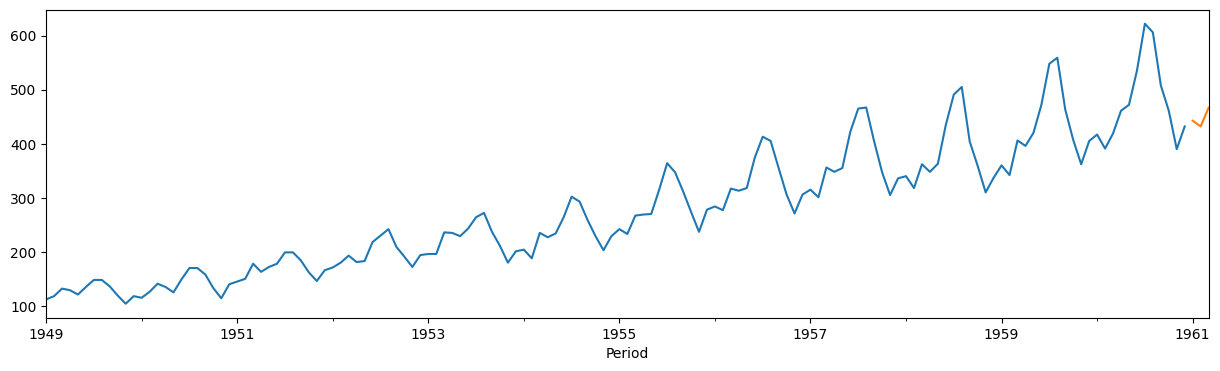

In [9]:
plt.rc("figure", figsize=(15, 4))
plt.rc("font", size=10)

y.plot()
y_pred.plot()

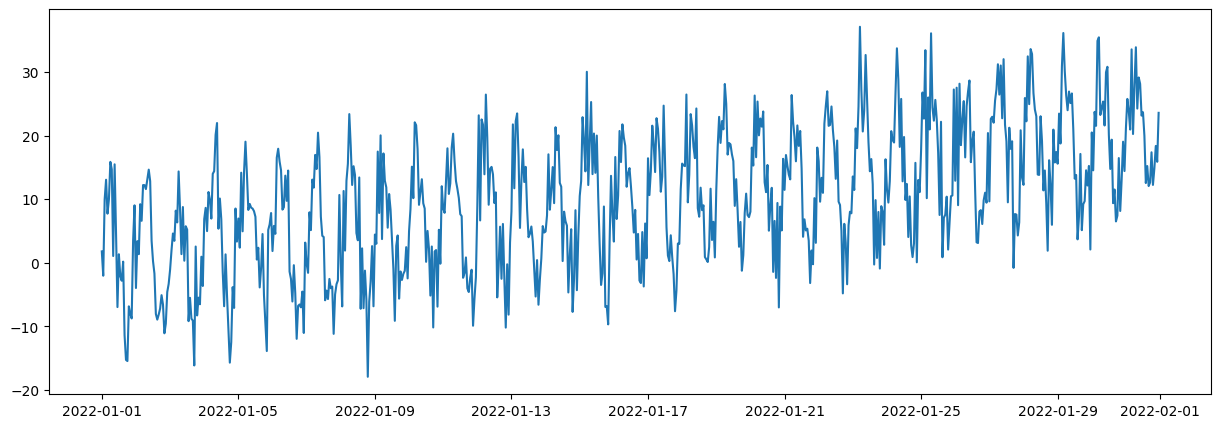

In [10]:
# Create Utility Metrics Function
def print_metrics(y_true, y_pred, model_name):
    mae_ = mean_absolute_error(y_true, y_pred)
    rmse_ = mean_squared_error(y_true, y_pred, square_root=True)
    mape_ = mean_absolute_percentage_error(y_true, y_pred)
    
    dict_ = {'MAE': mae_, 'RMSE': rmse_, 'MAPE': mape_}
    
    df = pd.DataFrame(dict_, index=[model_name])
    return df.round(decimals=2)

# Sample Data creation with sinusoidal signal, noise, and trend
n_size = 24*31 # hourly data
period = 24

time_index = pd.date_range('2022-01-01', periods=n_size, freq='H')

sinusoidal_signal = 10 * np.sin(2 * np.pi * np.arange(n_size) / period)
noise = np.random.normal(0, 5, size=n_size)  
trend = np.linspace(0, 20, n_size) 

data = { 'PJM_Load_MW': sinusoidal_signal + noise + trend }
df = pd.DataFrame(data, index=time_index)

plt.figure(figsize=(15, 5))
plt.plot(df)
plt.show()

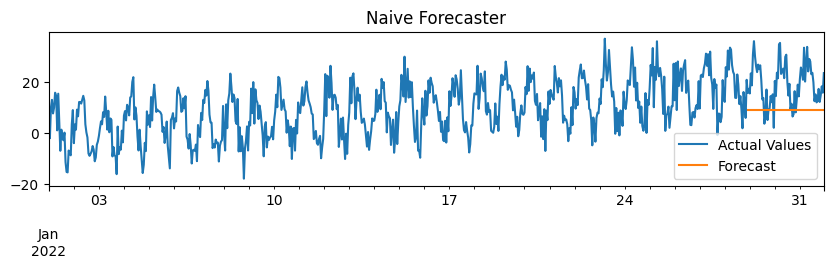

                    MAE   RMSE  MAPE
Naive Forecaster  11.01  13.07  0.55


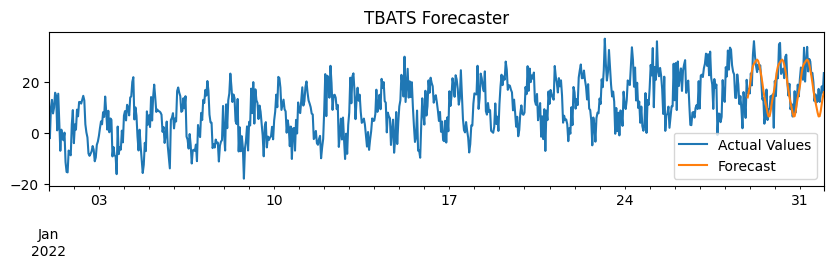

                   MAE  RMSE  MAPE
TBATS Forecaster  4.05  4.93  0.34


In [11]:
# = = = = = = = = = = = = = 
# Train Test Split

y = df['PJM_Load_MW']
test_perc = 0.1
test_size = np.floor(len(y)*test_perc).astype(int)

y_train, y_test = temporal_train_test_split(y, test_size=test_size)
fh = ForecastingHorizon(y_test.index, is_relative=False)

# = = = = = = = = = = = = = 
# Baseline Forecasting Model

forecaster = NaiveForecaster(strategy='mean')
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

fig, ax = plt.subplots(figsize=(10, 2))
df['PJM_Load_MW'].plot(title='Naive Forecaster', ax=ax)
y_pred.plot(ax=ax)
ax.legend(['Actual Values', 'Forecast'])
plt.show()

print(print_metrics(y_test, y_pred, 'Naive Forecaster'))

# = = = = = = = = = = = = = 
# TBATS Forecasting Model

forecaster = TBATS(
    use_box_cox=False,
    use_trend=False,
    use_damped_trend=False,
    sp=[24],
    use_arma_errors=False,
    n_jobs=1)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)

fig, ax = plt.subplots(figsize=(10, 2))
df['PJM_Load_MW'].plot(title='TBATS Forecaster', xlabel='', ax=ax)
y_pred.plot(ax=ax)
ax.legend(['Actual Values', 'Forecast'])
plt.show()

print(print_metrics(y_test, y_pred, 'TBATS Forecaster'))
